In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import time

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [2]:
# Directory for saving images
img_dir = '../model_outputs/W-DCGAN'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# Directory for saving models
model_dir = '../models/W-DCGAN'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(train_data, batch_size=256, shuffle=True)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, a 100 x 1 x 1 noise vector
            nn.ConvTranspose2d(100, 256, 7, 1, 0, bias=False),  # Output: 256 x 7 x 7
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # First upsampling step
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: 128 x 14 x 14
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Second upsampling step
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # Output: 64 x 28 x 28
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # To get the final output in 1 channel
            nn.ConvTranspose2d(64, 1, 1, 1, 0, bias=False),    # Output: 1 x 28 x 28
            nn.Tanh()  # Tanh to get outputs in the range of [-1,1]
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 1 x 28 x 28
            nn.Conv2d(1, 64, 3, 2, 1, bias=False),  # Output: 64 x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1, bias=False),  # Output: 128 x 7 x 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # The last convolutional layer uses a kernel smaller than 4
            nn.Conv2d(128, 256, 3, 1, 0, bias=False),  # Output: 256 x 5 x 5
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 5, 1, 0, bias=False),  # Output: 1 x 1 x 1
            # No need to reshape output since it is already a scalar
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [5]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    
    # Correct way to create grad_outputs
    grad_outputs = torch.ones_like(d_interpolates, requires_grad=False)
    
    # Calculate gradients w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [6]:
# Initialize models
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Optimizers
optimizer_G = optim.RMSprop(generator.parameters(), lr=0.00005)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00005)

# Number of critic iterations per one iteration of the generator
n_critic = 5

# Training Loop
epochs = 10000

lambda_gp = 10  # Gradient penalty lambda hyperparameter

discriminator_losses = []
generator_losses = []
loss_indices = []

for epoch in range(epochs):
    epoch_start = time.time()
    for i, (imgs, _) in enumerate(data_loader):
        real_imgs = imgs.cuda()

        # Train Discriminator
        optimizer_D.zero_grad()

        z = torch.randn(imgs.size(0), 100, 1, 1).cuda()
        fake_imgs = generator(z).detach()
        
        # Calculate discriminator output for real and fake images
        real_output = discriminator(real_imgs)
        fake_output = discriminator(fake_imgs)

        # Discriminator losses
        real_loss = -torch.mean(real_output)  # We maximize for real images
        fake_loss = torch.mean(fake_output)   # We minimize for fake images

        # Compute Gradient Penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        gradient_penalty = lambda_gp * gradient_penalty

        # Total Discriminator Loss
        loss_D = real_loss + fake_loss + gradient_penalty
        loss_D.backward()
        optimizer_D.step()
        
        # Store loss values and indices
        discriminator_losses.append(loss_D.item())
        
        # Train Generator -> In W-DCGAN Generator is trained once for every N times the discriminator is trained
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            gen_imgs = generator(z)
            # Generator loss (we try to fool the discriminator)
            gen_loss = -torch.mean(discriminator(gen_imgs))
            gen_loss.backward()
            optimizer_G.step()
            generator_losses.append(gen_loss.item())
            loss_indices.append(f"Epoch {epoch} Batch {i}")
        
        # Print loss periodically
        if i % 50 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(data_loader)}] [D loss: {loss_D.item()}] [G loss: {gen_loss.item()}]")
    
    # Save model weights
    torch.save(generator.state_dict(), os.path.join(model_dir, f'generator_epoch_{epoch}.pth'))
    torch.save(discriminator.state_dict(), os.path.join(model_dir, f'discriminator_epoch_{epoch}.pth'))

    # Save generated images after each epoch
    epoch_img_dir = os.path.join(img_dir, f'epoch_{epoch}')
    if not os.path.exists(epoch_img_dir):
        os.makedirs(epoch_img_dir)

    with torch.no_grad():
        z = torch.randn(10, 100, 1, 1).cuda()  # Generate 10 images
        sample_images = generator(z)
        sample_images = (sample_images + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
        
        epoch_img_dir = os.path.join(img_dir, f'epoch_{epoch}')
        if not os.path.exists(epoch_img_dir):
            os.makedirs(epoch_img_dir)

        for j, image in enumerate(sample_images):
            # Save each image
            save_path = os.path.join(epoch_img_dir, f'image_{j}.png')
            save_image(image, save_path)

    print("Epoch Time = ", time.time() - epoch_start)

/home/tanmay/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/tanmay/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[Epoch 0/10000] [Batch 0/235] [D loss: 0.4565155506134033] [G loss: 0.3259025812149048]
[Epoch 0/10000] [Batch 50/235] [D loss: -13.277772903442383] [G loss: 2.5113420486450195]
[Epoch 0/10000] [Batch 100/235] [D loss: -8.6228609085083] [G loss: -0.8514224290847778]
[Epoch 0/10000] [Batch 150/235] [D loss: -6.149401664733887] [G loss: -2.2934436798095703]
[Epoch 0/10000] [Batch 200/235] [D loss: -6.22286319732666] [G loss: -2.023159980773926]
Epoch Time =  27.265719175338745
[Epoch 1/10000] [Batch 0/235] [D loss: -6.472755432128906] [G loss: -2.5739946365356445]
[Epoch 1/10000] [Batch 50/235] [D loss: -7.287899017333984] [G loss: -1.3770382404327393]
[Epoch 1/10000] [Batch 100/235] [D loss: -8.631673812866211] [G loss: 0.3788967728614807]
[Epoch 1/10000] [Batch 150/235] [D loss: -11.17868423461914] [G loss: 4.934296131134033]
[Epoch 1/10000] [Batch 200/235] [D loss: -11.792387962341309] [G loss: 0.2579594850540161]
Epoch Time =  25.464876890182495
[Epoch 2/10000] [Batch 0/235] [D loss:

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (53710,) and (268547,)

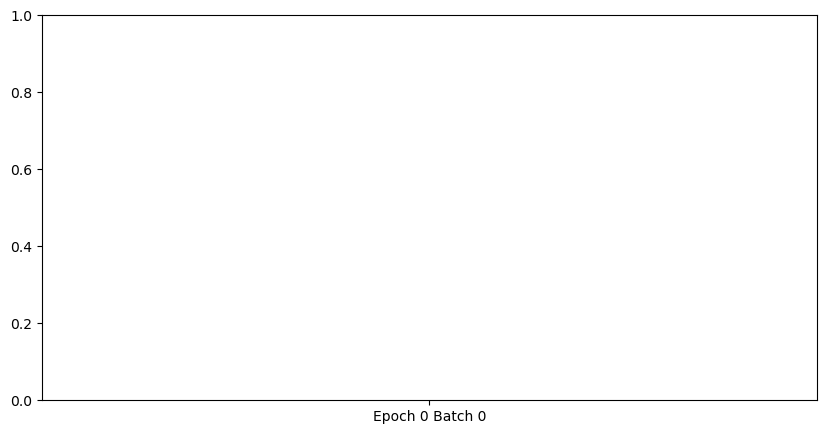

In [7]:
# Directory to save plots
plot_dir = './training_plots'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Plotting the loss curves after training
plt.figure(figsize=(10, 5))
plt.plot(loss_indices, discriminator_losses, label='Discriminator Loss')
plt.plot(loss_indices, generator_losses, label='Generator Loss', alpha=0.7)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'loss_plot.png'))  # Save the figure to file
plt.show()

In [8]:
import pickle
# Save the loss lists using pickle
loss_data = {
    'loss_indices': loss_indices,
    'discriminator_losses': discriminator_losses,
    'generator_losses': generator_losses
}
with open(os.path.join('loss_data.pkl'), 'wb') as f:
    pickle.dump(loss_data, f)